# Wright-Fisher Simulations

*in progress*

## Imports / configuration

In [193]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import GPy as gp

%autoreload 2

# import helper functions
import sys
sys.path.append("src")
import simulator as sim

# configure plot style
sns.set_context("poster")
sns.set_style("whitegrid", 
              {"axes.facecolor": "1.0", 
               "axes.edgecolor": "0.5",
               "grid.linestyle": "-",
              })
plt.style.use("whitegrid.mplstyle")

## Simulation

Simulate allele frequencies

In [195]:
p = 50000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # number of generations to sim 700*25 17500
F = sim.simulate_frequencies(p, n_e, max_gen)

Simulate genotypes

In [196]:
n = 20 # number of sampled individuals

# sampled time points
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)

Simulate reads

In [197]:
eps = .01 # error rate
lamb = .5 # average coverage
Y, C = sim.simulate_reads(X, eps, lamb)

Plot a hist of the coverage distribution for a the first individual

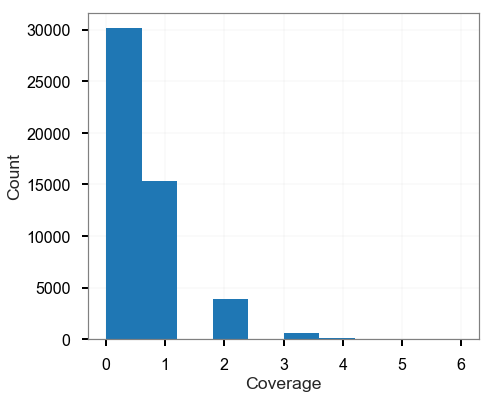

In [198]:
plt.hist(C[0,:]);
plt.xlabel("Coverage");
plt.ylabel("Count");

Plot some example trajectories

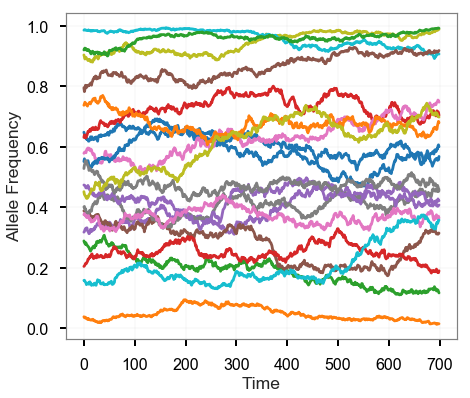

In [199]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(max_gen), F[:,j])
    
plt.xlabel("Time");
plt.ylabel("Allele Frequency");

Compute the population heterozygosity

In [200]:
H = 2 * F * (1 - F) # for all time points
h_true = np.sum(H, axis=1) / p
h = h_true[t] # for sampled time points

Compute an estimate of heterozygosity from genotypes

In [201]:
h_hat = sim.est_het_geno(X)

Plot population heterozygosity against time

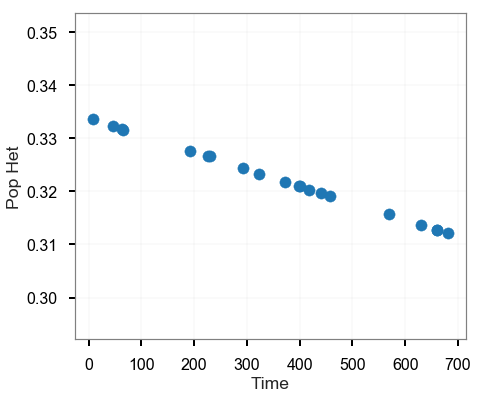

In [202]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("Pop Het");

Plot estimated heterozygosity against time

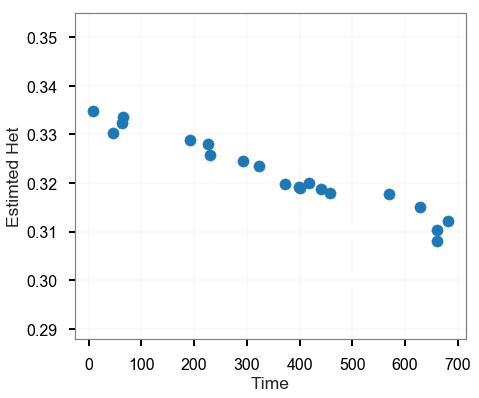

In [203]:
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Estimted Het");

## Inference

Fit a Gaussian Process regression model with a Matern kernal. We use an emprical Bayes approach where the marginal likelihood is maximized to estimate hyper parameters of the covariance kernal and then posterior is then analytically computed ...

In [204]:
#kern = gp.kern.Matern52(1) # set the kernal
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()

# fixing the lengthscale
#model[".*lengthscale"] = 12 * n_e
#model[".*lengthscale"].fix()

In [205]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 82.3 ms, sys: 467 µs, total: 82.7 ms
Wall time: 82.7 ms


Fitting this is incredibly quick!

## Critique

Here is a plot of the posterior mean and variance output by the analytical posterior of the Gaussian Process model

 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


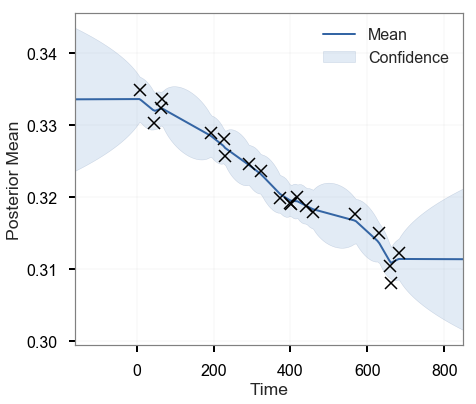

In [206]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx', mew=1.5);

Here is a plot of the posterior mean against the population heterozygosity

0.9946313794022781

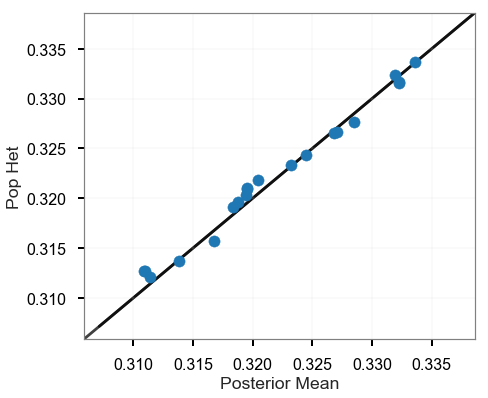

In [207]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
plt.xlabel("Posterior Mean");
plt.ylabel("Pop Het");

# compute correlation
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

Here is a plot of the naive heterozygosity estimate

0.978151541339409

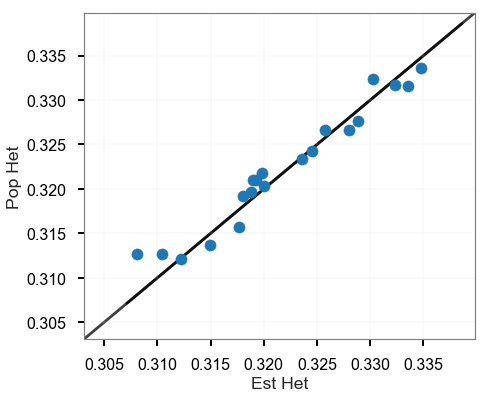

In [208]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
plt.xlabel("Est Het");
plt.ylabel("Pop Het");

# compute correlation
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]

Here are the fitted kernal parameters

In [209]:
model.kern

Exponential.,value,constraints,priors
variance,0.1041196024035393,+ve,
lengthscale,1517151.3534711644,+ve,


In [210]:
lengthscale = model.kern.lengthscale[0]

It seems the GP does provides a better fit than just the naive approach of computing the MLE of heterozygosity from the genotypes!

### Effect of the lengthscale

Lets try running the simulation with fewer SNPs

In [211]:
p = 2000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # number of generations to sim 700*25 17500
F = sim.simulate_frequencies(p, n_e, max_gen)

n = 20
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)
h_hat = sim.est_het_geno(X)

In [212]:
#kern = gp.kern.Matern52(1) # set the kernal
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()

In [213]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 64.8 ms, sys: 459 µs, total: 65.3 ms
Wall time: 65.3 ms


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:212: RuntimeWarning:invalid value encountered in multiply


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


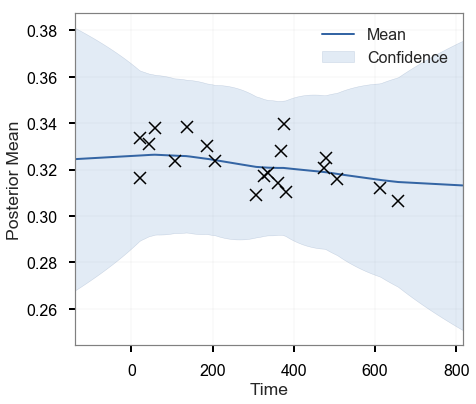

In [214]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx',mew=1.5)

0.9544469377060788

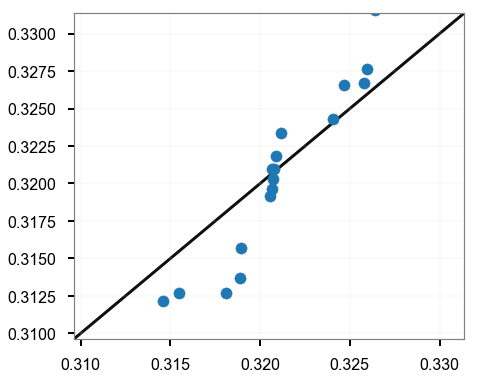

In [215]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

0.5099264116815689

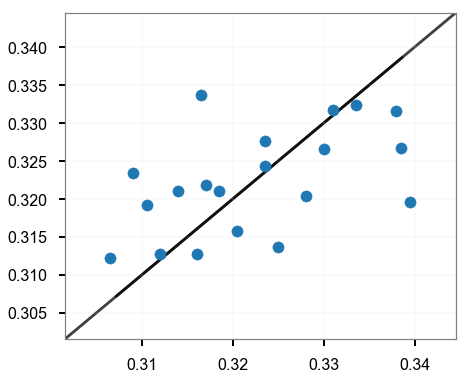

In [216]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]

Now lets try fixing the lengthscale to $12 N_e$

In [217]:
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()
model[".*lengthscale"] = 12 * n_e
model[".*lengthscale"].fix()

array([0])

In [218]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.9 ms


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


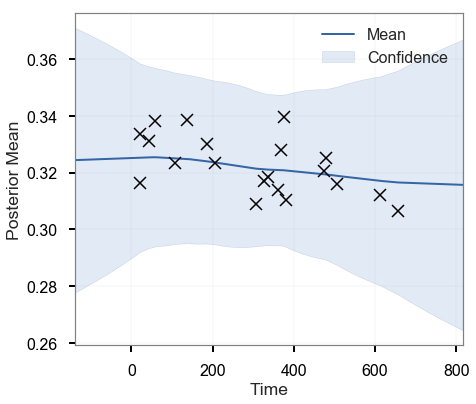

In [219]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx',mew=1.5)

0.9641134162746362

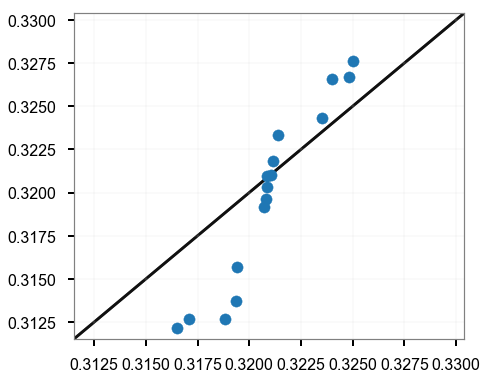

In [220]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

0.5099264116815689

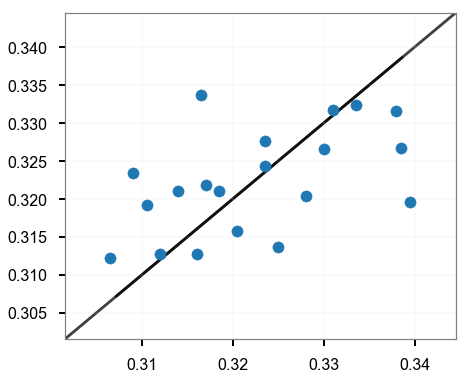

In [221]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]